# 1. Initialization

In [1]:
# PACKAGES & CONSTANTS DECLARATIONS #
#####################################

# Function to install missing packages
InstallPackages <- function(oPackageList) {
  for (sPackage in oPackageList) {
    if (!require(sPackage, character.only = TRUE)) {
      install.packages(sPackage, repos = "http://cran.r-project.org")
      library(sPackage, character.only = TRUE)
    }
  }
}

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

global_iRandomSeed <- 13654
set.seed(global_iRandomSeed)  # for reproducibility

# Constants for data dimensions
N_OBSERVATIONS <- 1000
N_VARIABLES <- 2000
global_UseParallelization = 1
global_bZeroImputationBehaviour = 1
global_TrainTestRatio = 0.7

# If needed, enable CPU cores parallelization #
if (global_UseParallelization == 1) {
    library(doParallel)
    global_iCoreNumber <- detectCores() - 1
    registerDoParallel(cores = global_iCoreNumber)
}

# List of required packages
oRequiredPackages <- c("elasticnet","reshape2", "ggplot2", "tidyr", "dplyr", "MASS", "Matrix", "stats")

# Install missing packages
InstallPackages(oRequiredPackages)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Duration :", elapsed_time, "seconds"))

[1] "Current Time : 2024-11-15 17:33:56"


Warning message:
"le package 'doParallel' a été compilé avec la version R 4.4.2"
Le chargement a nécessité le package : foreach

Warning message:
"le package 'foreach' a été compilé avec la version R 4.4.2"
Le chargement a nécessité le package : iterators

Warning message:
"le package 'iterators' a été compilé avec la version R 4.4.2"
Le chargement a nécessité le package : parallel

Le chargement a nécessité le package : elasticnet

Le chargement a nécessité le package : lars

Loaded lars 1.3


Le chargement a nécessité le package : reshape2

Warning message:
"le package 'reshape2' a été compilé avec la version R 4.4.2"
Le chargement a nécessité le package : ggplot2

Warning message:
"le package 'ggplot2' a été compilé avec la version R 4.4.2"
Le chargement a nécessité le package : tidyr


Attachement du package : 'tidyr'


L'objet suivant est masqué depuis 'package:reshape2':

    smiths


Le chargement a nécessité le package : dplyr


Attachement du package : 'dplyr'


Les objets sui

[1] "Current Time : 2024-11-15 17:33:57"
[1] "Duration : 1.033 seconds"


# 2. Data Generation

In [4]:
Get_Preprocessed_Data <- function(oDataSet) {
  Get_the_Mode <- function(x) {
    ux <- unique(na.omit(x))
    ux[which.max(tabulate(match(x, ux)))]
  }

  if (global_bZeroImputationBehaviour == 1) {
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else((is.na(.) | (. == 0)), mean(., na.rm = TRUE), .)))
  } else if (global_bZeroImputationBehaviour == 0) {    
      oDataSet <- oDataSet %>%
        mutate(across(where(is.numeric), ~ if_else(is.na(.), mean(., na.rm = TRUE), .)))
  }

  # Replace NA by the mode.
  oDataSet <- oDataSet %>%
    mutate(across(where(is.factor), ~ if_else(is.na(.), Get_the_Mode(.), .)))

  return(oDataSet)
}

In [6]:
# DATASET 01 => ECG data simulation - METHOD 1 #
################################################

library(MASS)
library(Matrix)
library(stats) 

# Generating the primary signal with three peaks
oDataMatrix <- matrix(rnorm(N_OBSERVATIONS * N_VARIABLES), N_OBSERVATIONS, N_VARIABLES)  # Noise
oDataMatrix[, 500:600] <- oDataMatrix[, 500:600] + 3  # First pic
oDataMatrix[, 1000:1100] <- oDataMatrix[, 1000:1100] + 5  # Second pic larger
oDataMatrix[, 1500:1550] <- oDataMatrix[, 1500:1550] + 4  # Third pic

head(oDataMatrix)

-0.6100957,-2.2838241,0.9052235,1.2051385,-0.64605656,-0.4725147,0.16250286,0.43222059,-0.1116868,-0.5577356,⋯,0.5875022,-0.3966999,-0.95851412,0.27755354,0.60925006,0.2247902,0.3018861,-0.6591092,0.6944057,0.80641497
2.4719819,0.4983001,-1.0134916,0.1434646,0.39829065,1.1066103,-1.05693189,-1.95948796,1.1986478,-0.6504203,⋯,-0.8956244,0.3069883,-0.56626072,1.29392202,0.09802744,-1.2612885,1.0727587,0.6297057,0.3284295,0.01136185
-1.2731934,0.3219907,-0.5836844,0.9739179,1.02804516,0.6784761,-1.69874142,0.03055361,1.8836789,1.3726508,⋯,-1.2677556,-0.4475286,-0.07350372,1.42005338,-0.12888341,-0.2253548,-2.3279263,0.4672057,-0.2780532,-0.96980510
-1.2668964,0.5124661,-0.6538665,0.7163708,0.33970804,0.0716993,-0.39724525,1.32882454,0.1681060,-1.4425758,⋯,-0.9506863,0.1986291,0.23063389,0.36477539,-0.93815875,-0.6034744,2.1754620,-1.1873056,-0.2507239,0.33317895
-0.5176653,1.4421975,-0.4198708,1.3971723,0.04838105,1.5356482,-0.26180353,0.82720225,-0.8168025,0.9527402,⋯,2.2018520,2.3468666,-0.62309658,0.03602509,0.02859458,-0.2880436,-0.4609935,-0.1136205,0.4415357,-1.22201168
0.8047194,0.7299144,-0.4389403,-0.6120929,-1.48362302,-0.4174105,0.09031339,-1.46809131,0.7278725,-0.9117783,⋯,-0.9587811,-0.6805548,0.61428861,0.03257025,-0.72462627,-0.7461787,-0.2130763,1.3523708,-1.0760534,0.44431045


# 3. Data Exploration

In [9]:
# Define train and test sets             #
##########################################

iTrainIndices <- sample(1:nrow(oDataMatrix), size = global_TrainTestRatio * nrow(oDataMatrix))
oTrainData <- oDataMatrix[iTrainIndices, ]
oTestData <- oDataMatrix[-iTrainIndices, ]  # Remaining data for testing

In [11]:
oDataMatrix

-0.61009574,-2.28382406,0.90522355,1.20513853,-0.64605656,-0.472514738,0.16250286,0.43222059,-0.111686838,-0.55773556,⋯,0.5875022,-0.39669992,-0.95851412,0.27755354,0.60925006,0.22479020,0.30188608,-0.65910922,0.69440568,0.80641497
2.47198195,0.49830013,-1.01349159,0.14346465,0.39829065,1.106610288,-1.05693189,-1.95948796,1.198647841,-0.65042033,⋯,-0.8956244,0.30698830,-0.56626072,1.29392202,0.09802744,-1.26128852,1.07275870,0.62970571,0.32842946,0.01136185
-1.27319337,0.32199075,-0.58368441,0.97391789,1.02804516,0.678476088,-1.69874142,0.03055361,1.883678948,1.37265085,⋯,-1.2677556,-0.44752859,-0.07350372,1.42005338,-0.12888341,-0.22535481,-2.32792631,0.46720568,-0.27805315,-0.96980510
-1.26689636,0.51246613,-0.65386650,0.71637078,0.33970804,0.071699303,-0.39724525,1.32882454,0.168105972,-1.44257584,⋯,-0.9506863,0.19862913,0.23063389,0.36477539,-0.93815875,-0.60347439,2.17546196,-1.18730556,-0.25072389,0.33317895
-0.51766530,1.44219751,-0.41987075,1.39717229,0.04838105,1.535648247,-0.26180353,0.82720225,-0.816802514,0.95274017,⋯,2.2018520,2.34686655,-0.62309658,0.03602509,0.02859458,-0.28804364,-0.46099352,-0.11362053,0.44153574,-1.22201168
0.80471938,0.72991441,-0.43894032,-0.61209292,-1.48362302,-0.417410530,0.09031339,-1.46809131,0.727872458,-0.91177834,⋯,-0.9587811,-0.68055482,0.61428861,0.03257025,-0.72462627,-0.74617867,-0.21307633,1.35237083,-1.07605338,0.44431045
-0.98284779,0.06508965,-1.14601591,0.50384656,-0.97425867,0.636790994,2.13808381,0.43793635,0.156300220,1.66166810,⋯,0.8231065,-1.32125547,0.04534404,0.61845364,-2.06489888,0.24543393,-0.34757368,-0.39625366,0.51910077,-1.88097209
0.11920111,1.00344651,-0.35224937,1.16469209,0.29890090,0.526784281,0.33206550,1.92550621,-1.127494378,-0.75662204,⋯,2.4612450,0.65173060,-0.85956402,1.04619221,0.21761050,0.08914387,0.20162463,1.90207030,-0.73039464,0.61841309
1.86008736,-0.66416227,-0.23008443,1.05502242,-0.68944929,-1.748259920,-0.76453149,0.05018590,0.143084236,-0.72184008,⋯,0.3605711,1.14358338,0.03039719,-1.71710462,1.64476841,1.64687601,-0.52908728,0.95050479,0.43256017,0.35486205
0.21277743,0.75348580,-0.03551887,-0.62894575,1.80646977,0.189346672,1.32998288,0.66063255,1.246035508,-2.12583945,⋯,0.7460478,0.59208627,-0.33993337,0.62206930,0.73140918,0.50493040,-1.37574022,-0.98419843,-0.34920451,0.28905302
0.34047112,-0.33583583,0.35212456,-0.79412170,-0.84909340,-1.622216835,1.66293895,-0.52010777,0.691241273,0.94563631,⋯,1.4683516,-1.09331444,1.77940955,-1.73714159,0.02015427,-0.33957273,0.79314871,-1.18456665,-1.38822736,-0.25817167


In [13]:
dim(oDataMatrix)
dim(oTrainData)
dim(oTestData)

[1] 1000 2000

[1]  700 2000

[1]  300 2000

In [15]:
oTestData

-1.26689636,0.51246613,-0.65386650,0.71637078,0.3397080,0.07169930,-0.39724525,1.328824538,0.1681060,-1.44257584,⋯,-0.9506863,0.19862913,0.23063389,0.364775391,-0.9381587515,-0.603474392,2.175461956,-1.18730556,-0.25072389,0.33317895
0.80471938,0.72991441,-0.43894032,-0.61209292,-1.4836230,-0.41741053,0.09031339,-1.468091306,0.7278725,-0.91177834,⋯,-0.9587811,-0.68055482,0.61428861,0.032570249,-0.7246262687,-0.746178673,-0.213076325,1.35237083,-1.07605338,0.44431045
0.11920111,1.00344651,-0.35224937,1.16469209,0.2989009,0.52678428,0.33206550,1.925506208,-1.1274944,-0.75662204,⋯,2.4612450,0.65173060,-0.85956402,1.046192214,0.2176105033,0.089143871,0.201624627,1.90207030,-0.73039464,0.61841309
1.86008736,-0.66416227,-0.23008443,1.05502242,-0.6894493,-1.74825992,-0.76453149,0.050185904,0.1430842,-0.72184008,⋯,0.3605711,1.14358338,0.03039719,-1.717104616,1.6447684094,1.646876013,-0.529087284,0.95050479,0.43256017,0.35486205
0.53532404,-1.39733014,-0.54829840,0.40848027,0.2742023,-0.14539690,-0.56751771,2.178902695,1.3705237,1.11282746,⋯,-1.0143383,1.14034866,0.96857116,-0.953526395,-0.7652399819,-0.378528973,-0.348610477,-0.33833396,0.75914755,1.53850608
-0.34367375,0.16551359,0.21857630,-1.94450473,1.3550865,0.28089987,1.22567084,0.101224830,0.7249372,1.82983339,⋯,-0.5337207,0.62462688,-0.29268689,-0.515241157,-2.5734399897,0.214906367,-0.642098127,0.07913921,0.50836072,-0.20422998
-0.90815720,-1.04817889,0.66331312,0.03860341,0.1250767,0.19550832,0.21318405,-1.014198476,1.2679397,0.19314953,⋯,1.5874536,0.02100426,-0.34387760,0.915176066,1.0346862636,-0.422798438,-1.168700980,-1.96878994,0.73428530,0.95986946
0.51002815,-0.60201944,-0.16579643,0.12204907,0.6118302,-1.03138100,-0.01704622,-0.251009917,-1.3530823,-1.24776901,⋯,1.3684256,2.40867451,-1.57814215,-1.337372522,0.8576281900,0.362862915,-0.076535562,0.83125963,-1.24099487,0.84225817
0.50885779,0.60059265,-0.15184349,-0.37546612,-1.1007554,2.67212039,0.72903765,0.984589614,0.1809636,0.25665904,⋯,-0.3744142,0.28572934,-0.71646042,-3.257471730,-0.2771678709,1.144360496,0.074512861,-1.89953505,-0.46983713,0.04772840
0.05477688,-1.17258843,-0.33224528,0.65064078,1.5969170,-1.17261897,-0.88703881,0.497052292,3.3542247,0.81812267,⋯,1.0378719,-0.08624495,1.05230049,0.315063071,-0.3383507704,0.899447383,-1.147991500,-0.52315188,-0.61117841,-1.10015845
-0.28381462,1.09933700,0.69280117,-0.84564204,0.2468246,2.05247157,1.12498049,1.151995250,-0.7977317,0.21916717,⋯,0.2070428,-0.44017089,2.32167099,-1.065220247,0.0585267754,0.218990946,-0.338826276,-2.48428717,1.20012338,0.87322790


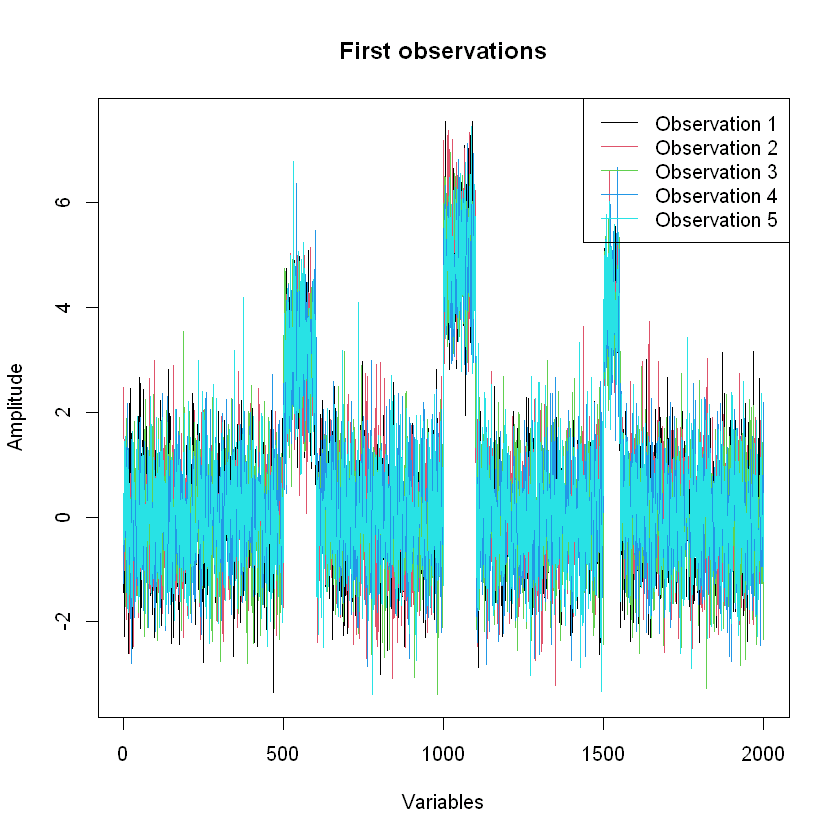

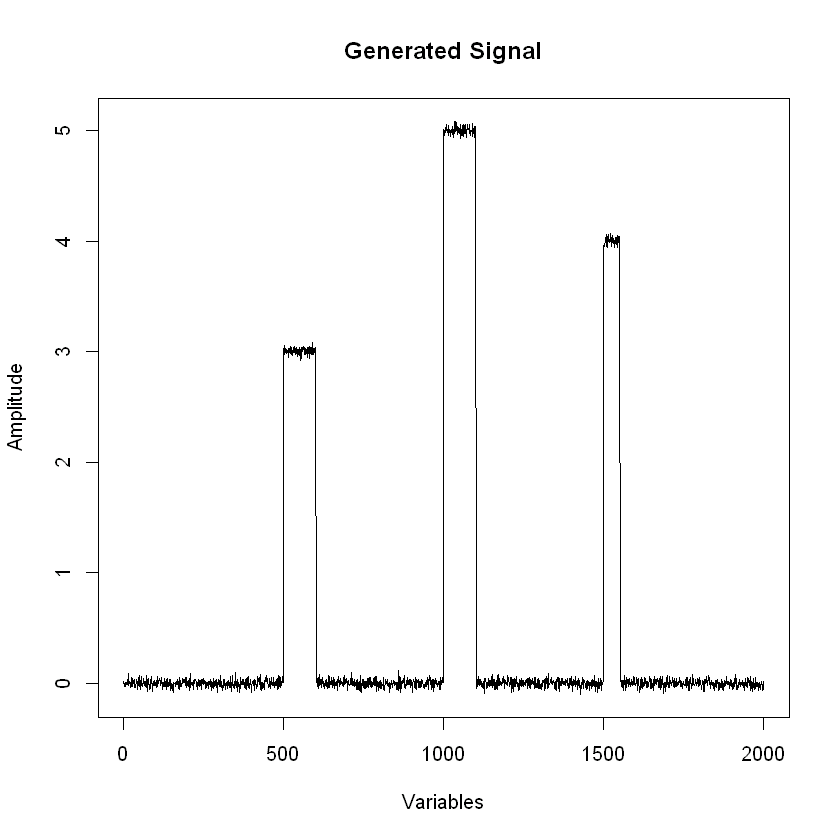

In [17]:
# Ploting first observations             #
##########################################

matplot(t(oDataMatrix[1:5, ]), type = "l", lty = 1, col = 1:5,
        main = "First observations",
        xlab = "Variables", ylab = "Amplitude")
legend("topright", legend = paste("Observation", 1:5), col = 1:5, lty = 1)

# Ploting mean of the generated signal   #
##########################################

mean_signal <- colMeans(oDataMatrix)

plot(mean_signal, type = "l", main = "Generated Signal", xlab = "Variables", ylab = "Amplitude")

In [19]:
Analyze_PCA <- function(X, numAxes = 50, explainedVarianceThreshold = 70) {
  pca <- prcomp(X, center = TRUE, scale. = TRUE)
  
  variance <- (pca$sdev^2 / sum(pca$sdev^2)) * 100
  cat(paste0("Variance explained by the first ", numAxes, " axes: ", sum(variance[1:numAxes]), "\n"))
  
  cum_variance <- cumsum(variance)
  
  num_components <- which(cum_variance >= explainedVarianceThreshold)[1]
  cat(paste("Number of principal components:", num_components, "to have", explainedVarianceThreshold, "% of variance\n"))
  
  d <- data.frame(PCAxes = seq_along(variance), Variance = variance, CumulativeVariance = cum_variance)

  library(ggplot2)
  p1 <- ggplot(d, aes(PCAxes, Variance)) +
    geom_col(fill = "skyblue") +
    labs(title = "Variance Explained by Each Principal Component", 
         x = "Principal Component", y = "Variance (%)") +
    theme_minimal()
  
  p2 <- ggplot(d, aes(PCAxes, CumulativeVariance)) +
    geom_line(color = "blue") +
    geom_point() +
    labs(title = "Cumulative Variance Explained", 
         x = "Principal Component", y = "Cumulative Variance (%)") +
    geom_hline(yintercept = explainedVarianceThreshold, linetype = "dashed", color = "red") +
    annotate("text", x = num_components, y = explainedVarianceThreshold + 5, 
             label = paste("Components:", num_components), color = "red") +
    theme_minimal()
  
  print(p1)
  print(p2)

  return(list(Variance = variance, CumulativeVariance = cum_variance, NumComponents = num_components))
}

Variance explained by the first 15 axes: 4.1482498761301
Number of principal components: 404 to have 70 % of variance


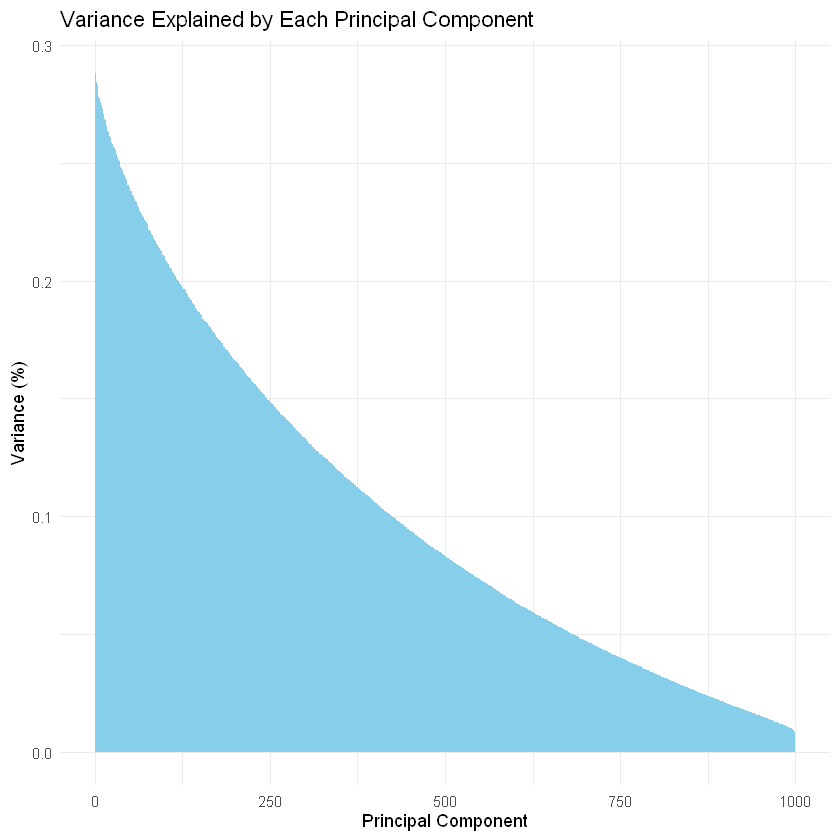

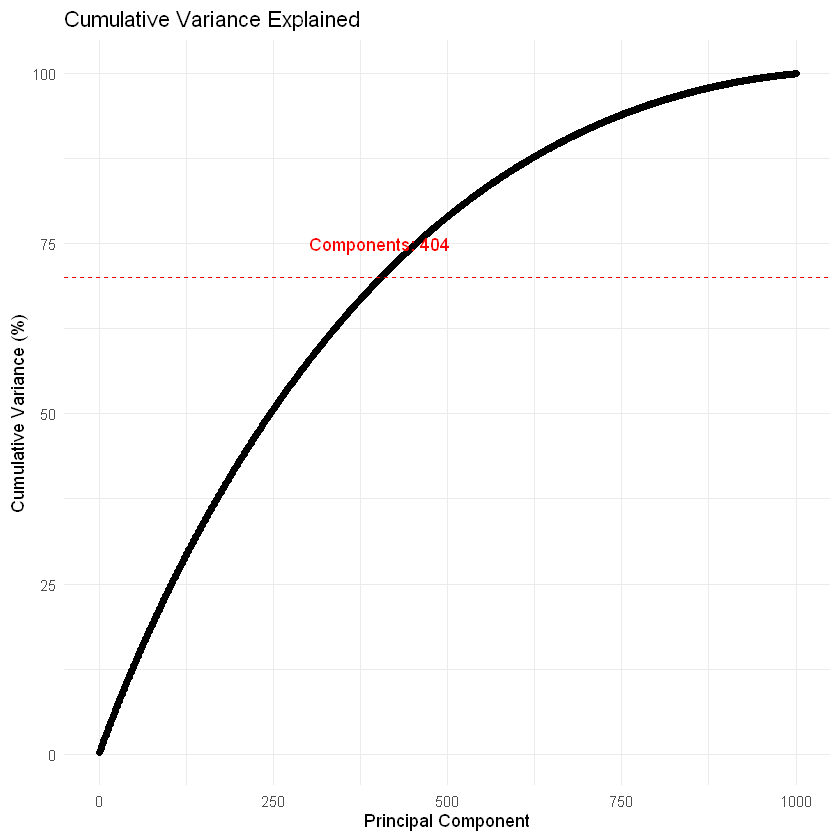

In [21]:
# PCA Exploration                        #
##########################################

oPCAAnalysis <- Analyze_PCA(oDataMatrix, numAxes = 15, explainedVarianceThreshold = 70)

In [23]:
# Create the functions to compute the evaluation criteria

Get_RMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_RMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_RMSE() - Error : Input data contains NA value(s).")
  }
  return(sqrt(mean((rActual - rPredicted)^2, na.rm = TRUE)))
}

Get_MSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_MSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_MSE() - Error : Input data contains NA value(s).")
  }
  return(mean((rActual - rPredicted)^2, na.rm = TRUE))
}

Get_NMSE <- function(rActual, rPredicted) {
  if (length(rActual) != length(rPredicted)) {
    stop("Get_NMSE() - Error : Vectors rActual & rPredicted must have the same lenght.")
  }
  if (any(is.na(rActual)) || any(is.na(rPredicted))) {
    stop("Get_NMSE() - Error : Input data contains NA value(s).")
  }

  rMean_Squared_Error <- sum((rActual - rPredicted)^2)
  rMean_Variance_Error <- sum((rActual - mean(rActual))^2)

  if (rMean_Variance_Error == 0) {
    warning("Get_NMSE() - Error : Division / 0.")
    return(NA)
  }

  return(rMean_Squared_Error / rMean_Variance_Error)
}

# 4. Standard PCA

In [26]:
Perform_Standard_PCA <- function(trainData, testData, numComponents = NULL, varianceThreshold = NULL) {

  selectedCols <- NULL
    
  # Step 1: Select variables based on variance if a threshold is provided
  if (!is.null(varianceThreshold)) {
    colVariances <- apply(trainData, 2, var)  # Calculate variances for each column
    selectedCols <- colVariances > varianceThreshold  # Identify columns with variance above the threshold
    trainData <- trainData[, selectedCols]  # Subset training data
    testData <- testData[, selectedCols]  # Subset test data
  } else {
    selectedCols <- trainData      
  }      
  
  # Step 2: Set number of components to number of columns if not provided
  if (is.null(numComponents)) {
    numComponents <- ncol(trainData)
  }
  
  # Step 3: Perform PCA on training data
  oPcaResult <- prcomp(trainData, center = TRUE, scale. = TRUE)

  plot(oPcaResult$x[, 1:2], main = "Standard PCA", xlab = "PC1", ylab = "PC2")
    
  # Step 4: Project test data onto principal components
  oTestScores <- predict(oPcaResult, newdata = testData)[, 1:numComponents]
  
  # Step 5: Reconstruct test data
  oReconstructedData <- oTestScores %*% t(oPcaResult$rotation[, 1:numComponents])
  oReconstructedData <- scale(oReconstructedData, center = FALSE, scale = 1/oPcaResult$scale)
  oReconstructedData <- sweep(oReconstructedData, 2, oPcaResult$center, "+")

  if (!all(dim(oReconstructedData) == dim(testData))) {
    stop("Mismatch in dimensions between testData and reconstructed data")
  }
    
  # Step 6: Evaluate reconstruction
  dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedData))
  dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedData))
  dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedData))

  result <- list(RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE)    
  if (!is.null(varianceThreshold)) {
    result$ActiveVariables <- sum(selectedCols)  # Add the count of selected columns if applicable
  } else {
    result$ActiveVariables <- numComponents
  }

  return(result)
}

[1] "Current Time : 2024-11-15 17:34:20"
[1] "Number of Components: 397"
[1] "Standard PCA - RMSE: 0.896574181171694"
[1] "Standard PCA - MSE: 0.803845262343694"
[1] "Standard PCA - NMSE: 0.280013412794913"
[1] "Current Time : 2024-11-15 17:34:24"
[1] "Standard PCA computation time : 3.505 seconds"


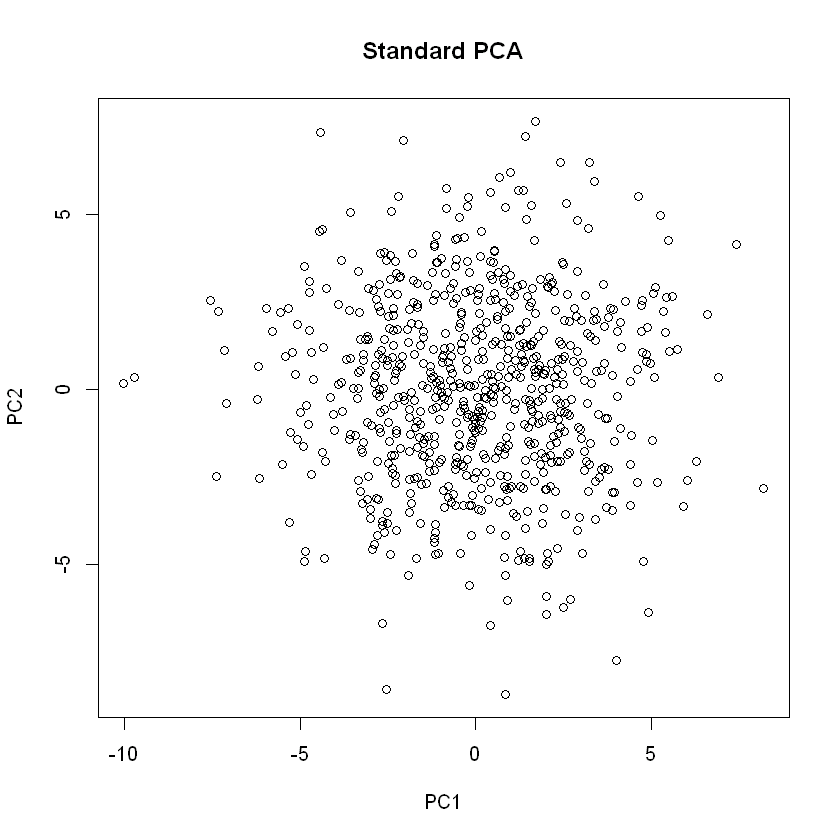

In [28]:
# Standard PCA on the entire DATASET 01  #
##########################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# First step => Find the number of components explaining 95% of the variance
oPCAResult <- prcomp(oTrainData, center = TRUE, scale. = TRUE)
dExplained_Variance <- cumsum(oPCAResult$sdev^2) / sum(oPCAResult$sdev^2)
iNumComponents <- which(dExplained_Variance >= 0.80)[1]
print(paste("Number of Components:", iNumComponents))

# Perform Standard PCA
oStandardPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, NULL)

print(paste("Standard PCA - RMSE:", oStandardPCAResults$RMSE))
print(paste("Standard PCA - MSE:", oStandardPCAResults$MSE))
print(paste("Standard PCA - NMSE:", oStandardPCAResults$NMSE))

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Standard PCA computation time :", elapsed_time, "seconds"))

# 5. PCA based on Variance Selection

[1] "Current Time : 2024-11-15 17:34:31"


$RMSE
[1] 0.7801547

$MSE
[1] 0.6086413

$NMSE
[1] 0.2190451

$ActiveVariables
[1] 1009

[1] "Current Time : 2024-11-15 17:34:32"
[1] "Variance Selection PCA computation time : 0.963 seconds"


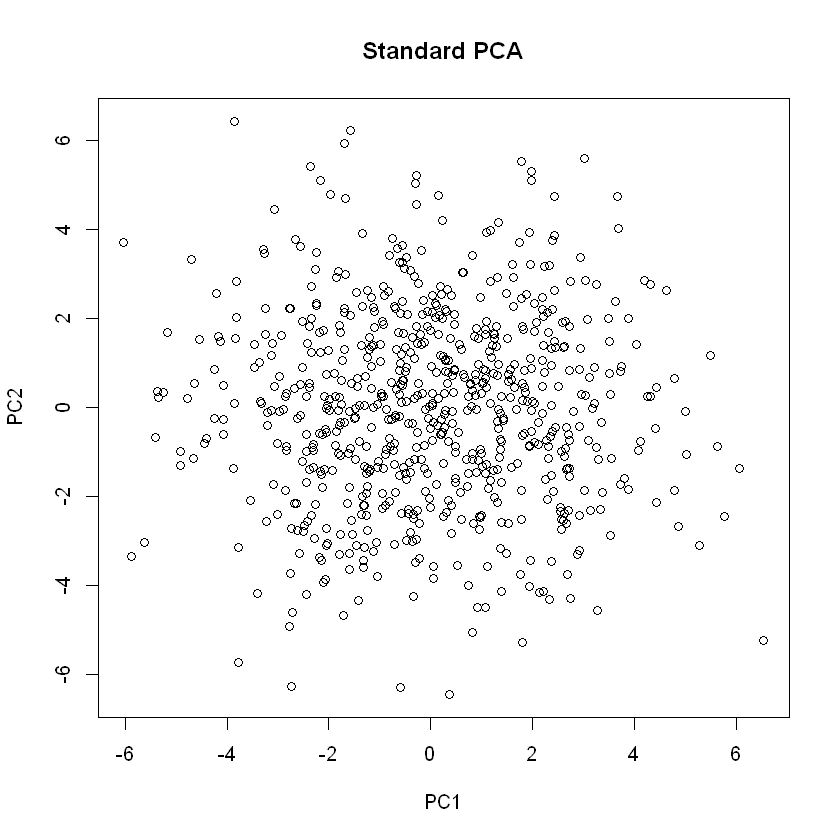

In [31]:
# Variance Selection PCA on the entire DATASET 01  #
####################################################

# Cell execution time 15/11/2024 : 1.929 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Perform Variance Selection PCA
oVarPCAResults <- Perform_Standard_PCA(oTrainData, oTestData, numComponents = iNumComponents, varianceThreshold = 1)

oVarPCAResults

# Display end time and elapsed time
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Variance Selection PCA computation time :", elapsed_time, "seconds"))

# 6. Sparse PCA

In [34]:
Perform_Sparse_PCA <- function(trainData, testData, paraValues, numComponents = 1) {
  library(elasticnet)
  results <- data.frame(Para = paraValues, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
  
  # Parallel execution with exported functions
  results <- foreach(i = 1:length(paraValues), .combine = rbind,
                     .packages = c("elasticnet"), 
                     .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    iPara <- paraValues[i]
    oSparsePcaResult <- spca(trainData, K = numComponents, sparse = "penalty", para = rep(iPara, numComponents))
    
    if (!is.null(oSparsePcaResult$loadings)) {
      oTestScores <- testData %*% oSparsePcaResult$loadings
      oReconstructedData <- oTestScores %*% t(oSparsePcaResult$loadings)
      
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedData))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedData))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedData))
      
      # Nombre de variables actives
      active_vars <- sum(oSparsePcaResult$loadings != 0)
      
      result_row <- data.frame(Para = iPara, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE, ActiveVariables = active_vars)

      non_zero_loadings <- sum(oSparsePcaResult$loadings != 0)
      cat("Para =", iPara, "- Non-zero loadings:", non_zero_loadings, "\n")
      # Save loadings for further analisys.
      saveRDS(oSparsePcaResult$loadings, file = paste0("loadings_sparse_para_", iPara, ".rds"))
        
      cat("Para =", iPara, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "- Active Variables:", active_vars, "\n")
    } else {
      cat("Para =", iPara, "- No valid loadings returned by spca\n")
      result_row <- data.frame(Para = iPara, RMSE = NA, MSE = NA, NMSE = NA, ActiveVariables = NA)
    }
    
    result_row
  }
  
  return(results)
}

In [36]:
# Sparse PCA on the entire DATASET 01   #
#########################################

# Cell execution time 15/11/2024 : 355.319 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Penalty list
oParaValues <- c(1, 2, 3, 5, 10, 15, 20, 25, 30)

# Perform Sparse PCA
oSparsePCAResults <- Perform_Sparse_PCA(oTrainData, oTestData, oParaValues, numComponents = 1)

print(oSparsePCAResults)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Sparse PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-11-15 17:34:54"
  Para     RMSE      MSE     NMSE ActiveVariables
1    1 1.768094 3.126158 1.088973             689
2    2 1.768094 3.126155 1.088973             683
3    3 1.768094 3.126155 1.088972             669
4    5 1.768089 3.126140 1.088967             652
5   10 1.768081 3.126111 1.088957             608
6   15 1.768070 3.126070 1.088943             577
7   20 1.768074 3.126086 1.088949             540
8   25 1.768058 3.126029 1.088929             501
9   30 1.768042 3.125971 1.088908             452
[1] "Current Time : 2024-11-15 17:39:23"
[1] "Sparse PCA computation time : 268.387 seconds"


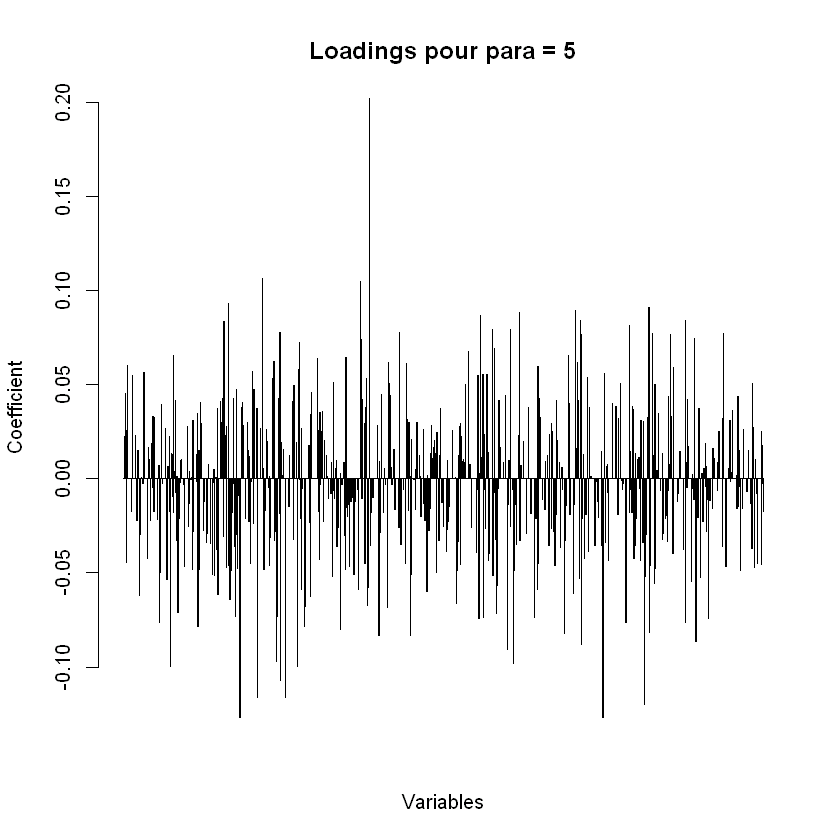

In [40]:
# Visualiser les loadings pour une valeur spécifique de para
iPara <- 5  # Exemple
loadings <- readRDS(paste0("loadings_sparse_para_", iPara, ".rds"))
barplot(loadings[, 1], main = paste("Loadings pour para =", iPara), xlab = "Variables", ylab = "Coefficient")


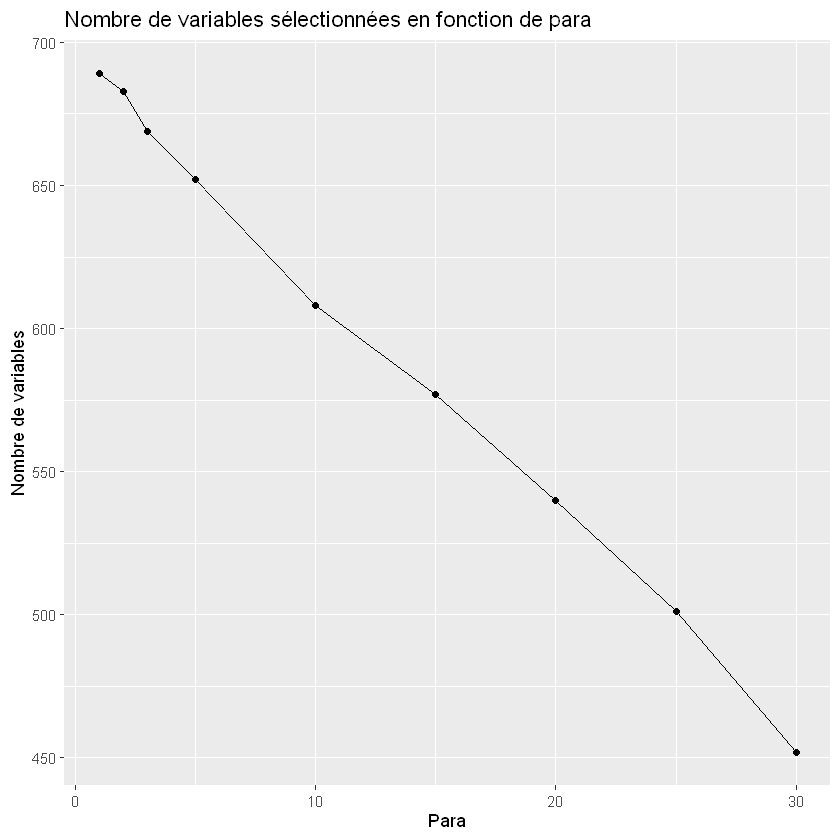

In [42]:
# Après avoir collecté les résultats
ggplot(oSparsePCAResults, aes(x = Para, y = ActiveVariables)) +
  geom_point() +
  geom_line() +
  labs(title = "Nombre de variables sélectionnées en fonction de para", x = "Para", y = "Nombre de variables")




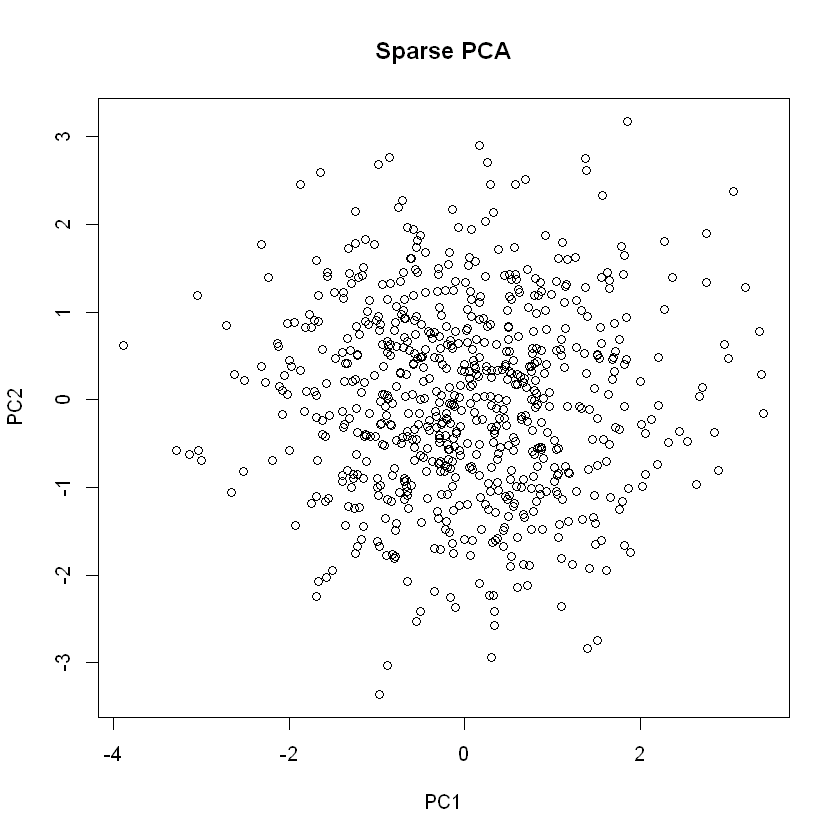

In [50]:

plot(pca_sparse$x[, 1:2], main = "Sparse PCA",
     xlab = "PC1", ylab = "PC2")

# THRESHOLD PCA

In [53]:
Perform_Threshold_PCA <- function(trainData, testData, thresholdValues, numComponents = 1) {
  results <- data.frame(Threshold = thresholdValues, RMSE = NA, MSE = NA, NMSE = NA)
  
  # Parallel execution with exported functions
  results <- foreach(i = 1:length(thresholdValues), .combine = rbind, 
                     .packages = c("stats"), 
                     .export = c("Get_RMSE", "Get_MSE", "Get_NMSE")) %dopar% {
    dThreshold <- thresholdValues[i]
    
    # Selecting variables with variance above the threshold
    oVariances <- apply(trainData, 2, var)
    oSelectedIndices <- which(oVariances > dThreshold)
    
    if (length(oSelectedIndices) > 0) {
      # Applying PCA on the selected subset of variables
      oTrainDataSelected <- trainData[, oSelectedIndices, drop = FALSE]
      oTestDataSelected <- testData[, oSelectedIndices, drop = FALSE]
      
      oPcaResult <- prcomp(oTrainDataSelected, center = TRUE, scale. = TRUE)
      
      # Project test data
      oTestScores <- predict(oPcaResult, newdata = oTestDataSelected)[, 1:numComponents, drop = FALSE]
      
      # Reconstruct test data
      oReconstructedData <- oTestScores %*% t(oPcaResult$rotation[, 1:numComponents, drop = FALSE])
      oReconstructedData <- scale(oReconstructedData, center = FALSE, scale = 1 / oPcaResult$scale)
      oReconstructedData <- sweep(oReconstructedData, 2, oPcaResult$center, "+")
      
      # Expand reconstructed data to original dimensions
      oReconstructedFull <- matrix(0, nrow = nrow(testData), ncol = ncol(testData))
      oReconstructedFull[, oSelectedIndices] <- oReconstructedData
      
      # Evaluate
      dRMSE <- Get_RMSE(as.vector(testData), as.vector(oReconstructedFull))
      dMSE <- Get_MSE(as.vector(testData), as.vector(oReconstructedFull))
      dNMSE <- Get_NMSE(as.vector(testData), as.vector(oReconstructedFull))
      
      # Store results
      result_row <- data.frame(Threshold = dThreshold, RMSE = dRMSE, MSE = dMSE, NMSE = dNMSE)
      
      cat("Threshold =", dThreshold, "- RMSE:", dRMSE, "- MSE:", dMSE, "- NMSE:", dNMSE, "\n")
    } else {
      cat("Threshold =", dThreshold, "- No variables selected\n")
      result_row <- data.frame(Threshold = dThreshold, RMSE = NA, MSE = NA, NMSE = NA)
    }
    
    result_row
  }
  
  return(results)
}

In [55]:
# Threshold PCA on the entire DATASET 01   #
############################################

# Cell execution time 15/11/2024 : 13.563 seconds

start_time <- Sys.time()
print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))

# Threshold list
thresholdValues <- seq(0.05, 1, by = 0.05)

# Perform Threshold PCA
oThresholdPCAResults <- Perform_Threshold_PCA(oTrainData, oTestData, thresholdValues, numComponents = 1)

print(oThresholdPCAResults)

print(paste("Current Time :", format(Sys.time(), "%Y-%m-%d %H:%M:%S")))
elapsed_time <- round(difftime(Sys.time(), start_time, units = "secs"), 3)
print(paste("Threshold PCA computation time :", elapsed_time, "seconds"))

[1] "Current Time : 2024-11-15 17:42:57"
   Threshold     RMSE      MSE      NMSE
1       0.05 1.001147 1.002296 0.3491421
2       0.10 1.001147 1.002296 0.3491421
3       0.15 1.001147 1.002296 0.3491421
4       0.20 1.001147 1.002296 0.3491421
5       0.25 1.001147 1.002296 0.3491421
6       0.30 1.001147 1.002296 0.3491421
7       0.35 1.001147 1.002296 0.3491421
8       0.40 1.001147 1.002296 0.3491421
9       0.45 1.001147 1.002296 0.3491421
10      0.50 1.001147 1.002296 0.3491421
11      0.55 1.001147 1.002296 0.3491421
12      0.60 1.001147 1.002296 0.3491421
13      0.65 1.001147 1.002296 0.3491421
14      0.70 1.001147 1.002296 0.3491421
15      0.75 1.001147 1.002296 0.3491421
16      0.80 1.001147 1.002296 0.3491421
17      0.85 1.007354 1.014761 0.3534844
18      0.90 1.047832 1.097952 0.3824633
19      0.95 1.193356 1.424098 0.4960739
20      1.00 1.453557 2.112828 0.7359875
[1] "Current Time : 2024-11-15 17:43:11"
[1] "Threshold PCA computation time : 14.217 seconds"


# 7. RESULTS

In [58]:
# Merging results array                 #
#########################################

library(reshape2)
library(tidyr)

# Convert named lists to numeric values
oStandardPCAResults$RMSE <- as.numeric(oStandardPCAResults$RMSE)
oStandardPCAResults$MSE <- as.numeric(oStandardPCAResults$MSE)
oStandardPCAResults$NMSE <- as.numeric(oStandardPCAResults$NMSE)
oSparsePCAResults$RMSE <- sapply(oSparsePCAResults$RMSE, as.numeric)
oSparsePCAResults$MSE <- sapply(oSparsePCAResults$MSE, as.numeric)
oSparsePCAResults$NMSE <- sapply(oSparsePCAResults$NMSE, as.numeric)
oThresholdPCAResults$RMSE <- sapply(oThresholdPCAResults$RMSE, as.numeric)
oThresholdPCAResults$MSE <- sapply(oThresholdPCAResults$MSE, as.numeric)
oThresholdPCAResults$NMSE <- sapply(oThresholdPCAResults$NMSE, as.numeric)

# New data frames
standardPCAResultsDF <- data.frame(Method = "Standard PCA", Parameter = 0, 
                                   RMSE = oStandardPCAResults$RMSE, 
                                   MSE = oStandardPCAResults$MSE, 
                                   NMSE = oStandardPCAResults$NMSE)

sparsePCAResultsDF <- data.frame(Method = "Sparse PCA", Parameter = oSparsePCAResults$Para, 
                                 RMSE = unlist(oSparsePCAResults$RMSE), 
                                 MSE = unlist(oSparsePCAResults$MSE), 
                                 NMSE = unlist(oSparsePCAResults$NMSE))

thresholdPCAResultsDF <- data.frame(Method = "Threshold PCA", Parameter = oThresholdPCAResults$Threshold, 
                                    RMSE = unlist(oThresholdPCAResults$RMSE), 
                                    MSE = unlist(oThresholdPCAResults$MSE), 
                                    NMSE = unlist(oThresholdPCAResults$NMSE))

# Combine all results
allResults <- rbind(standardPCAResultsDF, sparsePCAResultsDF, thresholdPCAResultsDF)
# Cleaning
allResults$Parameter <- replace_na(allResults$Parameter, 0)

allResults <- allResults %>%
  mutate(Global_Score = (RMSE + MSE + NMSE) / 3)

print(allResults)

          Method Parameter      RMSE       MSE      NMSE Global_Score
1   Standard PCA      0.00 0.8965742 0.8038453 0.2800134    0.6601443
2     Sparse PCA      1.00 1.7680945 3.1261581 1.0889735    1.9944087
3     Sparse PCA      2.00 1.7680937 3.1261553 1.0889725    1.9944072
4     Sparse PCA      3.00 1.7680936 3.1261550 1.0889724    1.9944070
5     Sparse PCA      5.00 1.7680895 3.1261404 1.0889673    1.9943991
6     Sparse PCA     10.00 1.7680810 3.1261105 1.0889569    1.9943828
7     Sparse PCA     15.00 1.7680696 3.1260703 1.0889429    1.9943609
8     Sparse PCA     20.00 1.7680742 3.1260864 1.0889485    1.9943697
9     Sparse PCA     25.00 1.7680580 3.1260289 1.0889285    1.9943385
10    Sparse PCA     30.00 1.7680416 3.1259712 1.0889084    1.9943071
11 Threshold PCA      0.05 1.0011472 1.0022957 0.3491421    0.7841950
12 Threshold PCA      0.10 1.0011472 1.0022957 0.3491421    0.7841950
13 Threshold PCA      0.15 1.0011472 1.0022957 0.3491421    0.7841950
14 Threshold PCA    

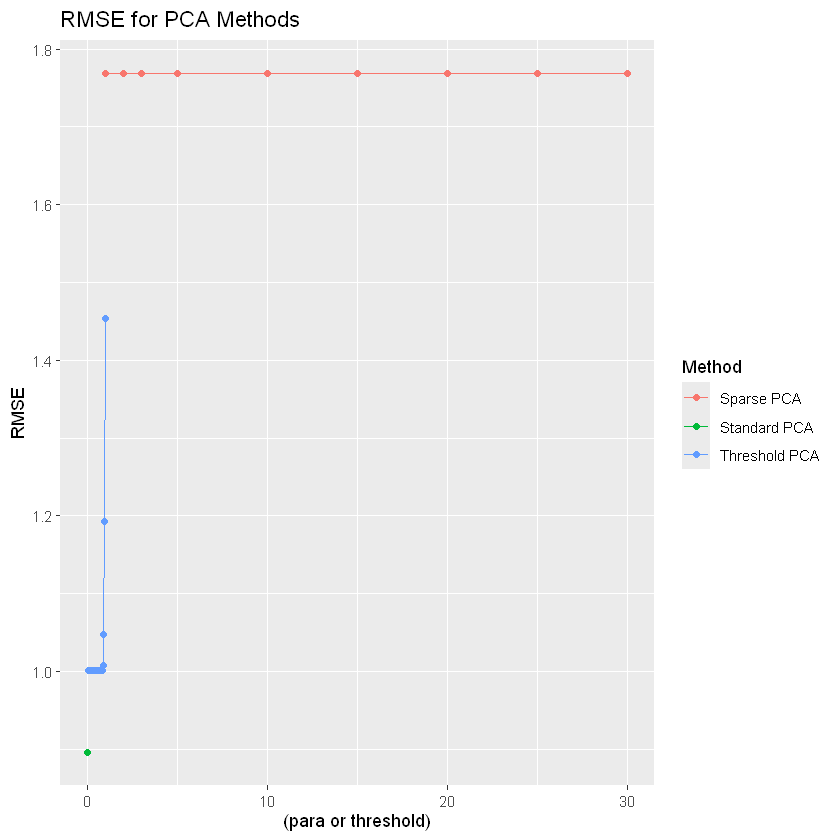

In [62]:
ggplot(allResults, aes(x = Parameter, y = RMSE, color = Method)) +
  geom_point() +
  geom_line() +
  labs(title = "RMSE for PCA Methods", x = "(para or threshold)", y = "RMSE")

In [64]:
# Computing a score                     #
#########################################

summaryDF <- allResults %>%
  group_by(Method) %>%
  summarise(
    Mean_RMSE = mean(RMSE),
    Mean_MSE = mean(MSE),
    Mean_NMSE = mean(NMSE)
  )

summaryDF <- summaryDF %>%
  mutate(Global_Score = (Mean_RMSE + Mean_MSE + Mean_NMSE) / 3)

print(summaryDF %>% arrange(Global_Score))  # Sorted by best global score...

# A tibble: 3 × 5
  Method        Mean_RMSE Mean_MSE Mean_NMSE Global_Score
  <chr>             <dbl>    <dbl>     <dbl>        <dbl>
1 Standard PCA      0.897    0.804     0.280        0.660
2 Threshold PCA     1.04     1.08      0.378        0.833
3 Sparse PCA        1.77     3.13      1.09         1.99 


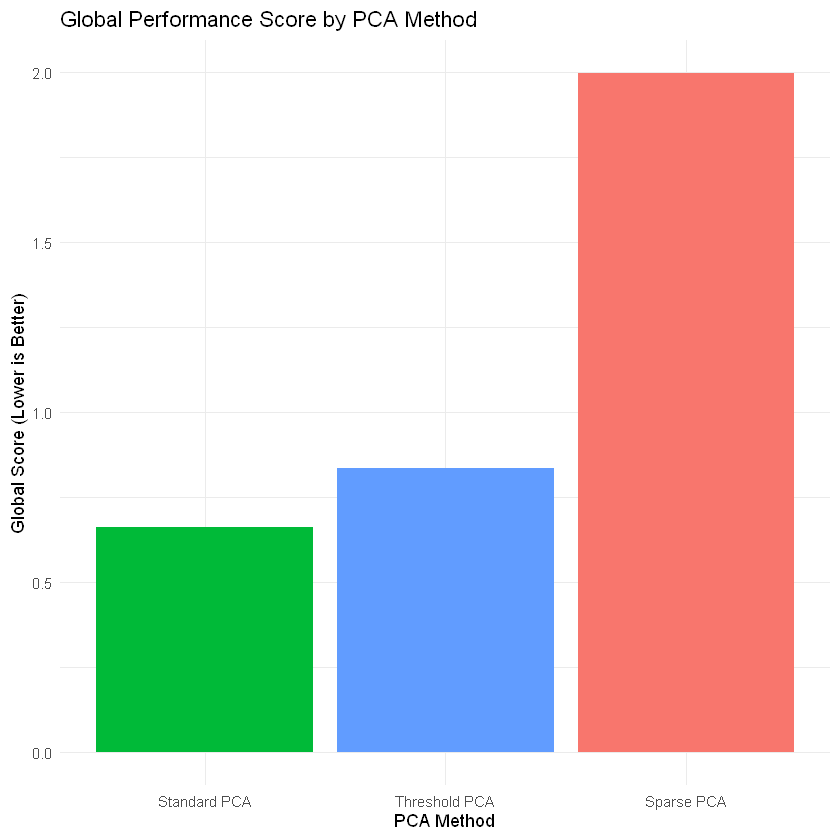

In [66]:
library(ggplot2)

ggplot(summaryDF, aes(x = reorder(Method, Global_Score), y = Global_Score, fill = Method)) +
  geom_bar(stat = "identity") +
  labs(title = "Global Performance Score by PCA Method",
       x = "PCA Method",
       y = "Global Score (Lower is Better)") +
  theme_minimal() +
  theme(legend.position = "none")

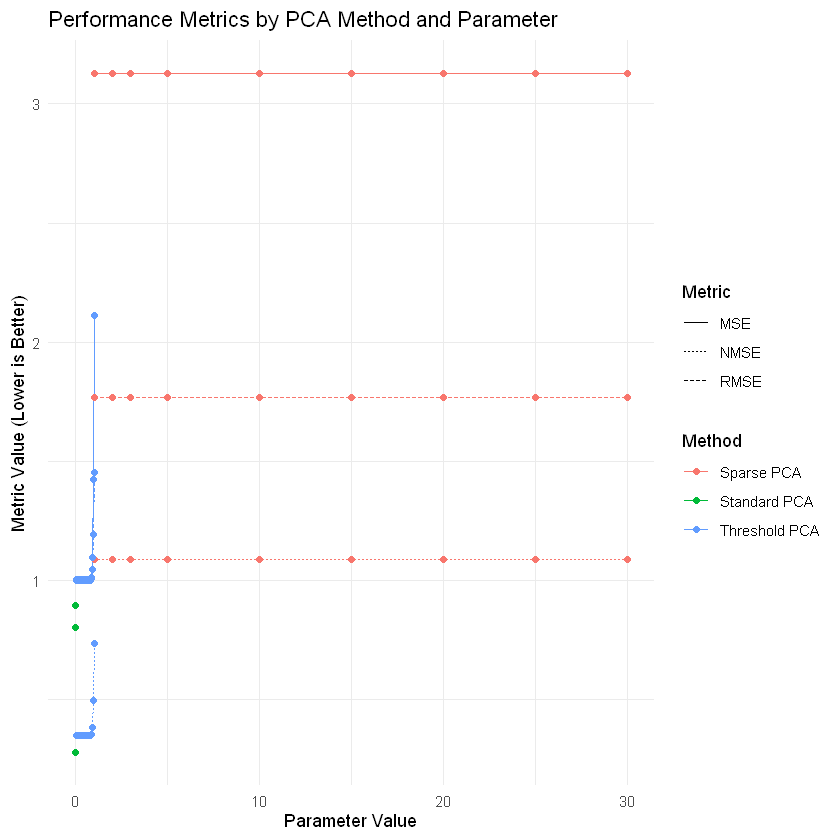

In [68]:
library(tidyr)

allResultsLong <- allResults %>%
  pivot_longer(cols = c("RMSE", "MSE", "NMSE"), names_to = "Metric", values_to = "Value")

ggplot(allResultsLong, aes(x = Parameter, y = Value, color = Method)) +
  geom_line(aes(linetype = Metric)) +
  geom_point() +
  labs(title = "Performance Metrics by PCA Method and Parameter",
       x = "Parameter Value",
       y = "Metric Value (Lower is Better)") +
  theme_minimal()

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


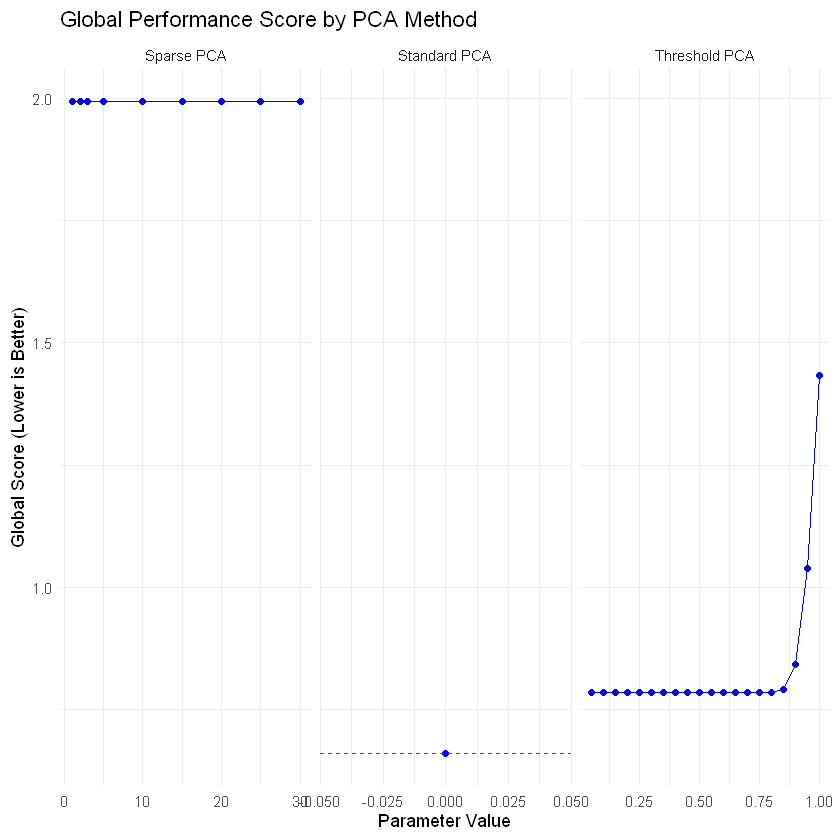

In [70]:
library(dplyr)
library(ggplot2)

# Compute vertical scale
global_min <- min(allResults$Global_Score, na.rm = TRUE)
global_max <- max(allResults$Global_Score, na.rm = TRUE)

ggplot(allResults, aes(x = Parameter, y = Global_Score)) +
  geom_line(aes(group = Method), color = "blue") +
  geom_point(color = "blue") +
  geom_hline(data = allResults %>% filter(Method == "Standard PCA"),
             aes(yintercept = Global_Score), linetype = "dashed", color = "red") +
  facet_wrap(~ Method, scales = "free_x") +
  labs(title = "Global Performance Score by PCA Method",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal() +
  coord_cartesian(ylim = c(global_min, global_max))


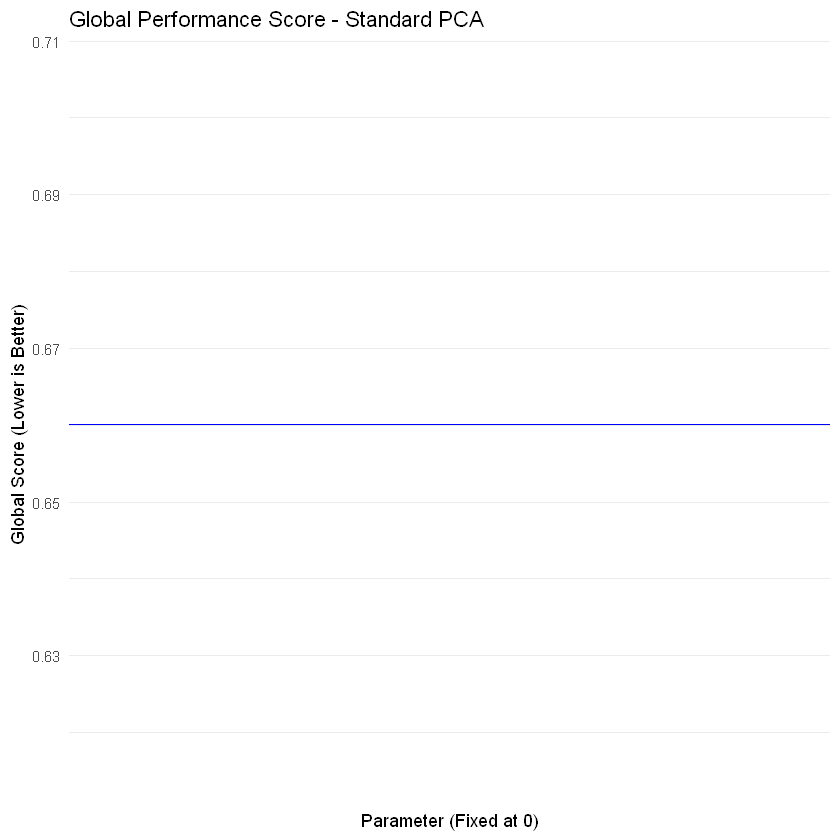

In [72]:
# Standard PCA
standardPCA <- allResults %>% filter(Method == "Standard PCA")

ggplot(standardPCA, aes(x = Parameter, y = Global_Score)) +
  geom_hline(aes(yintercept = Global_Score), color = "blue") +
  labs(title = "Global Performance Score - Standard PCA",
       x = "Parameter (Fixed at 0)",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

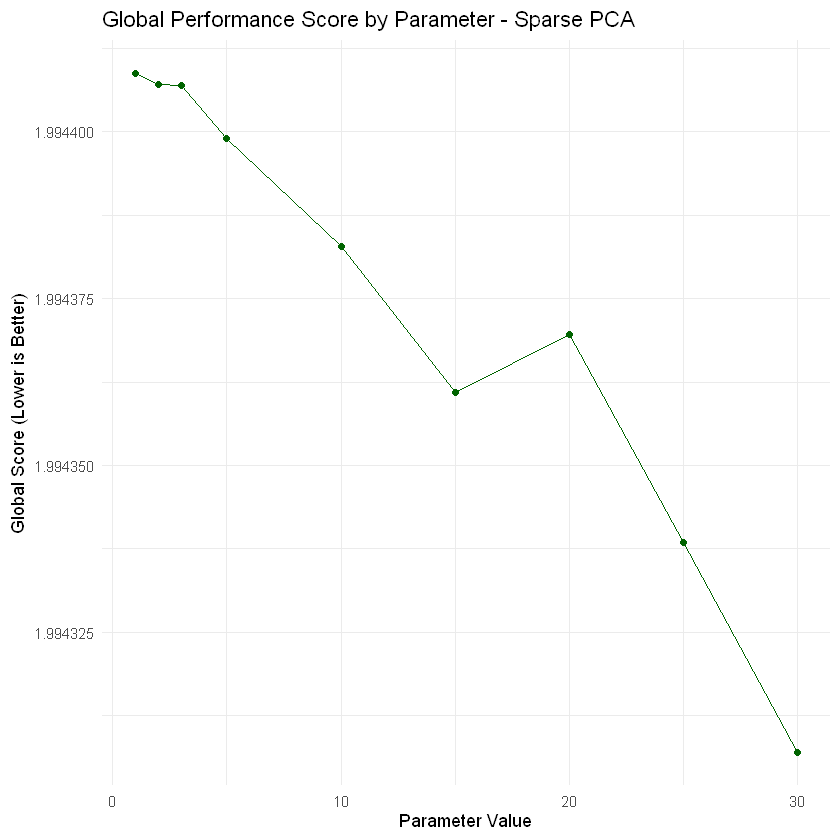

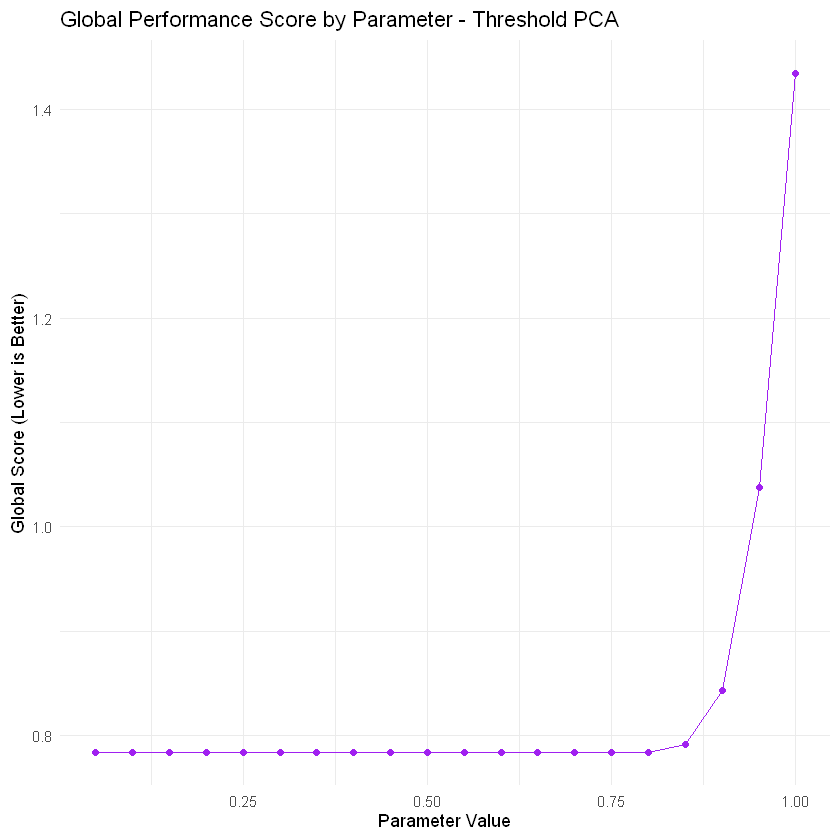

In [74]:
# Sparse PCA
sparsePCA <- allResults %>% filter(Method == "Sparse PCA")
ggplot(sparsePCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "darkgreen") +
  geom_point(color = "darkgreen") +
  labs(title = "Global Performance Score by Parameter - Sparse PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()

# Threshold PCA
thresholdPCA <- allResults %>% filter(Method == "Threshold PCA")
ggplot(thresholdPCA, aes(x = Parameter, y = Global_Score)) +
  geom_line(color = "purple") +
  geom_point(color = "purple") +
  labs(title = "Global Performance Score by Parameter - Threshold PCA",
       x = "Parameter Value",
       y = "Global Score (Lower is Better)") +
  theme_minimal()